<br> 
<span style="float: right; color: rgb(128, 128, 128); font-size:150%" >  <strong> Final Project - Milestone 1</span>
<span style="float: left; color: rgb(128, 128, 128); font-size:150%"> <strong>  42186 Model-based machine learning (F20)</span>    
    <br>  
  
    
    
  <span style="float: right; color: rgb(128, 128, 128)" >  <strong> Students:</span>
  <span style="float: left; color: rgb(128, 128, 128)"> <strong>  Professors:</span>
<div> 
      <br>  
<div>
  <span style="float: right" > Guðlaug Erlendsdóttir, s185717</span> 
  <span style="float: left"> Filipe Rodrigues</span>
<div> 
    <br>
  <span style="float: right" > Matthías Karl Karlsson, s182306</span> 
  <span style="float: left"> Francisco Camara Pereira</span>
    <br>
<div style="text-align: right"> Steinn Orri Erlendsson, s153716</div>
    
______________

In [108]:
# Use the entire screen
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.display import Image, display

--2020-04-23 18:02:42--  http://mlsm.man.dtu.dk/mbml/pystan_utils.py
Resolving mlsm.man.dtu.dk (mlsm.man.dtu.dk)... 192.38.87.226
Connecting to mlsm.man.dtu.dk (mlsm.man.dtu.dk)|192.38.87.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/x-python]
Saving to: ‘pystan_utils.py.9’

pystan_utils.py.9   100%[===================>]   2.60K  --.-KB/s    in 0.004s  

2020-04-23 18:02:43 (688 KB/s) - ‘pystan_utils.py.9’ saved [2661/2661]



## Table of Contents

### [1. Description of Project](#one)

### [2. Data](#two)

* #### [2.1 Data Collection and Preprocessing](#two.one)

### [3.Natural Language Preprocessing](#three)

### [4. Descriptive Stats](#four)

### [5. Research Question](#five)

### [6. Generative Story](#six)

### [7. PGM](#seven)

### [8. Inital STAN Model](#eight)

# Model-Based Machine Learning - Milestone 1

## The Simpsons - Topic Modeling with Latent Dirichlet Allocation


In this notebook, topic modeling through Latent Dirichlet Allocation is used in order to try anduncover the topics that have come up on episodes of The Simpsons through the years.

Attributes such as *rating* and *viewers* were extracted from [IMDB](IMDB) for the first 600 episodes of The Simpsons. Then, for each of these episodes, the plot was scraped from [The Simpsons Fandom](page) page. 

Natural Language Processing was deployed in order to represent the textual data better. Each episode's description was put through *TF-IDF analysis* in order to obtain a better representation of their description. 

By using Latent Dirichlet Allocation for topic modeling, the episodes can be seen as a mixture of topics, and a relationhip between what is happening in the episode and its rating could potentially be made. 



---


# 1. Description of Project<a class="anchor" id="one"></a>

For those that have ever watched the television show *The Simpsons*, it is quite known that the quality of episodes have dwindled over the past years. The show has been running for 30 years and it has long gone past its glory days. But what is the reason behind this decline in quality? In this notebook, the topics of each episode of *The Simpsons* is investigated and through *topic modeling* episodes are clustered together in order to see whether the topics of episodes have anything to do with their respective ratings. 

Ratings for 600 episodes were collected from [IMDB](www.imdb.com) and descriptions for each of those episodes was collected from [The Simpsons Wiki Fanpage](ons.fandom.com/wiki/List_of_Episodes). This information, along with additional information collected from [Wikipedia](www.wikipedia.org) such as viewers per episode and airdate, was used in order to create a data set.

The very popular topic model *Latent Dirichlet Allocation* was used in order to extract topic proportions and allocations for each episode. These topics were then investigated in order to see if there is any apparent relationship between the topic of episodes over the years and their declining ratings. 

# 2. Data<a class="anchor" id="two"></a>

In this section, the method of collecting and preprocessing both the *ratings* and *description* for each episode is shown. All of the data is collected through web scraping. The websites that were scraped were [IMDB](www.imdb.com), [Wikipedia](www.wikipedia.org), and [The Simpsons Fandom Wiki Page](simpsons.fandom.com/wiki/List_of_Episodes). 

There was a lot of data cleaning to be done, as there were a lot of missing values that resulted from the web scraping due to some inconstistency in the pages' setup. 

#### Importing packages

In [109]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib.request
import io
import re
import os
import os.path
import nltk, re, pprint
from nltk.tokenize import RegexpTokenizer
import sklearn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import collections
import colorsys
import warnings
warnings.filterwarnings("ignore")
from nltk import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image
sns.set(style="ticks", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 10)
#make margins smaller 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [110]:
from nltk.corpus import stopwords

In [111]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
#for char in ['episode','begins']:
#    stop_words.append(char)

[nltk_data] Downloading package stopwords to /home/steinn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Color Palettes**

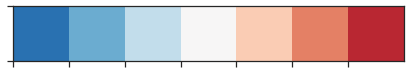

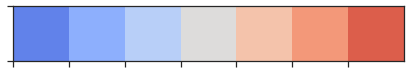

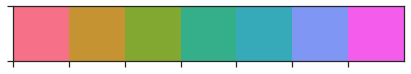

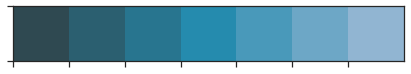

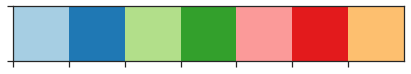

In [112]:
sns.palplot(sns.color_palette("RdBu_r", 7))
sns.palplot(sns.color_palette("coolwarm", 7))
sns.palplot(sns.color_palette("husl", 7))
sns.palplot(sns.color_palette("PuBuGn_d", 7))
sns.palplot(sns.color_palette("Paired", 7))


## 2.1 Data Collection and Preprocessing<a class="anchor" id="two.one"></a>

### Episode Information <a class="anchor" id="two.one.one"></a>

Getting all episode names, dates and relevant information is possible by scraping Wikipedia. This will serve as a basis for the episode information which will be used throughout the project. 

In [113]:
episode_1_20_url = 'https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1%E2%80%9320)#Episodes'
episode_21_31_url = "https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes"

In [114]:
res = requests.get(episode_1_20_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Simpsons Movie'):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
df_1 = pd.DataFrame(arr)
df_1.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 1 to 20:

In [115]:
df_1.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5
2,3,1,3,Homer's Odyssey,"January 21, 1990 (1990-01-21)",27.5


In [116]:
df_1.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
438,439,20,19,"Waverly Hills, 9-0-2-1-D'oh","May 3, 2009 (2009-05-03)",6.75
439,440,20,20,Four Great Women and a Manicure,"May 10, 2009 (2009-05-10)",5.16
440,441,20,21,Coming to Homerica,"May 17, 2009 (2009-05-17)",5.86


Now, the rest of the seasons are retrieved:

In [117]:
res = requests.get(episode_21_31_url).text
soup = BeautifulSoup(res,'html')
arr = []
next_season = 1
for table in soup.find_all('table', class_='wikiepisodetable'):
    if(table.previous.previous.previous.text != 'The Longest Daycare' and table.previous.previous.previous.text):
        season = table.previous.previous.previous.text.split('(')[1].split(')')[0].split(" ")[1]
        for row in table.find_all('tr')[1::1]:
            data = row.find_all(['th','td'])
            no = data[0].text
            no_in_season = data[1].text
            episode_name = data[2].text[1:len(data[2].text)-1] #Remove the " " 
            airdate = data[5].text
            viewers = data[7].text.split("[")[0]
            arr.append([no,season,no_in_season,episode_name,airdate,viewers])
        if(season=='30'):
            break
df_2 = pd.DataFrame(arr)
df_2.columns = ['no_overall','season','no_in_season','episode_name','airdate','viewers (millions)']

Seasons 21 to 30:

In [118]:
df_2.head(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
0,442,21,1,Homer the Whopper,"September 27, 2009 (2009-09-27)",8.31
1,443,21,2,Bart Gets a 'Z',"October 4, 2009 (2009-10-04)",9.32
2,444,21,3,The Great Wife Hope,"October 11, 2009 (2009-10-11)",7.5


In [119]:
df_2.tail(3)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions)
217,660,30,21,D'oh Canada,"April 28, 2019 (2019-04-28)",1.93
218,661,30,22,Woo-Hoo Dunnit?,"May 5, 2019 (2019-05-05)",1.79
219,662,30,23,Crystal Blue-Haired Persuasion,"May 12, 2019 (2019-05-12)",1.50


Concatinating them together will create the final dataframe for the episodes:

In [120]:
df_episodes = pd.concat([df_1,df_2])

In [121]:
df_episodes.reset_index(inplace=True)
df_episodes.drop('index',axis=1,inplace=True)

df_episodes['no_overall'] = df_episodes['no_overall'].apply(lambda x: int(x))
df_episodes['season'] = df_episodes['season'].apply(lambda x: int(x))
df_episodes['no_in_season'] = df_episodes['no_in_season'].apply(lambda x: int(x))

It is necessary to clean **season 28** of this dataframe is episodes **608** and **609** are consider to be the same episode, as can be seen below. Splitting the episode up into episode **608** and **609** will make the data make more sense, as the overall episode count will be linear. 

In [122]:
df_episodes.iloc[607]

no_overall                                   608609
season                                           28
no_in_season                                   1213
episode_name          The Great Phatsby Parts 1 & 2
airdate               January 15, 2017 (2017-01-15)
viewers (millions)                             6.90
Name: 607, dtype: object

In [123]:
df_episodes.drop(607,axis=0,inplace=True)

In [124]:
insert_into = pd.DataFrame(data = [{'no_overall':608, 'season':28,'no_in_season': 12, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}, {'no_overall':609, 'season':28,'no_in_season': 13, 
                            'episode_name':'The Great Phatsby','airdate': 'January 15, 2017 (2017-01-15)', 
                            'viewers (millions)': 6.90}], index=[607,608])

df_episodes = pd.concat([df_episodes.iloc[:608], insert_into, df_episodes[608:]])

### Episode Ratings <a class="anchor" id="two.one.two"></a>

Getting the ratings for each episode is possible by scraping IMDB. There exist several pages of ratings for the series on IMDB. Going through each one of them will yield every episode's rating:

In [125]:
imdb_ratings_url = 'https://www.imdb.com/list/ls052175596/?st_dt=&mode=simple&page={}&ref_=ttls_vw_smp&sort=release_date,asc'
pages = range(1,8)

In [126]:
ratings = []
for page in range(1,8):
    url = imdb_ratings_url.format(page)
    res = requests.get(url).text
    soup = BeautifulSoup(res,'html')
    container = soup.find('div',class_='lister')
    for item in container.find_all('div', class_='lister-item'):
        as_ = item.find('span',class_='lister-item-header').find_all('a')
        episode_name = as_[1].text
        rating = item.find('div',class_='col-imdb-rating').text.strip()
        ratings.append([episode_name,rating])

df_ratings = pd.DataFrame(ratings)
df_ratings.columns = ['episode_name','IMDB rating']

In [127]:
df_ratings.tail(10)

,episode_name,IMDB rating
669,"Todd, Todd, Why Hast Thou Forsaken Me?",6.4
670,"Bobby, It's Cold Outside",6.7
671,Hail to the Teeth,6
672,The Miseducation of Lisa Simpson,6.6
673,Frinkcoin,5.9
674,Bart the Bad Guy,7.3
675,Screenless,6.6
676,Better Off Ned,6.5
677,Highway to Well,7
678,The Incredible Lightness of Being a Baby,6.4


For this particular project, only the first 660 episodes will be investigated. This decision was made as the last episodes do not have as much description written about them as they are quite new. 

In [128]:
df_ratings = df_ratings[:661]

In [129]:
df_ratings.tail(2)

,episode_name,IMDB rating
659,Woo-Hoo Dunnit?,5.9
660,Crystal Blue-Haired Persuasion,5.8


Concatinating these two DataFrames will yield more informative data. However, a simple merge on the names will not do because the names are not exactly identical on IMDB and Wikipedia. The `NaN` values will be looked at and manually fixed: 

In [130]:
df_episodes_ratings = pd.merge(df_episodes, df_ratings, on='episode_name',how='left')

The following episodes do not get a rating after the join because the naming convention are different between IMDB and Wikipedia.

In [131]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
13,14,2,1,"Bart Gets an ""F""","October 11, 1990 (1990-10-11)",33.6,NaN
21,22,2,9,Itchy & Scratchy & Marge,"December 20, 1990 (1990-12-20)",22.2,NaN
28,29,2,16,"Bart's Dog Gets an ""F""","March 7, 1991 (1991-03-07)",23.9,NaN
88,89,5,8,Boy-Scoutz 'n the Hood,"November 18, 1993 (1993-11-18)",20.1,NaN
90,91,5,10,"$pringfield (or, How I Learned to Stop Worryin...","December 16, 1993 (1993-12-16)",17.9,NaN
123,124,6,21,The PTA Disbands!,"April 16, 1995 (1995-04-16)",11.8,NaN
127,128,6,25,Who Shot Mr. Burns? (Part One),"May 21, 1995 (1995-05-21)",15.0,NaN
128,129,7,1,Who Shot Mr. Burns? (Part Two),"September 17, 1995 (1995-09-17)",16.0,NaN
130,131,7,3,Home Sweet Homediddly-Dum-Doodily,"October 1, 1995 (1995-10-01)",14.5,NaN
134,135,7,7,King-Size Homer,"November 5, 1995 (1995-11-05)",17.0,NaN


A list of the names of the episodes that are missing their ratings can be created: 

In [132]:
missing = df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()].reset_index()
missing_episodes = missing['index']
for episode in missing_episodes:
    print(df_ratings.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating'])

Bart Gets an F 8.2
Itchy and Scratchy and Marge 8.1
Bart's Dog Gets an F 7.5
Boy Scoutz 'n the Hood 8.7
$pringfield (Or, How I Learned to Stop Worrying and Love Legalized Gambling) 8.6
The PTA Disbands 8.1
Who Shot Mr. Burns? Part One 9.2
Who Shot Mr. Burns? Part Two 9
Home Sweet Home-Dum-Diddly Doodily 8.4
King Size Homer 9
The Simpsons 138th Episode Spectacular! 7.5
Raging Abe Simpson and His Grumbling Grandson in 'The Curse of the Flying Hellfish' 8.4
Summer of 4'2" 8.4
El Viaje Misterioso De Nuestro Jomer 8.6
Homer vs. the 18th Amendment 8.9
Lisa Gets an 'A' 8.1
Homer Simpson in: 'Kidney Trouble' 7.3
Marge Simpson in 'Screaming Yellow Honkers' 7.3
The Old Man and the 'C' Student 7.3
Thirty Minutes Over Tokyo 8
Alone Again, Natura-Diddly 7.7
Lisa the Treehugger 7.1
Homr 8.1
Hungry Hungry Homer 7.5
Bye Bye Nerdy 6.6
I Am Furious Yellow 7.7
Papa's Got a Brand New Badge 7.8
Bart vs. Lisa vs. 3rd Grade 7.1
Today, I Am a Clown 6.4
I, (Annoyed Grunt)-Bot 7.3
Co-Dependent's Day 6.7
Thank G

As can be seen by comparing the two lists, these are the episodes that are missing a rating in the final dataframe. Now, an array can be created with the ratings of these episodes, extracted from `df_ratings`. 

In [133]:
missing_ratings = []
for episode in missing_episodes:
    missing_ratings.append([episode,df_episodes.iloc[episode]['episode_name'],df_ratings.iloc[episode]['IMDB rating']])

In [134]:
for episode in missing_ratings: 
    index = episode[0]
    rating = episode[2]
    df_episodes_ratings.at[index, 'IMDB rating'] = rating

In [135]:
df_episodes_ratings[df_episodes_ratings['IMDB rating'].isna()]

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating


The DataFrame holding each episode's information along with it's rating is now complete, but the airdate column can use a little bit of cleaning:

In [136]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7


In [137]:
df_episodes_ratings['year'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[0])
df_episodes_ratings['month'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[1].split('-')[0])
df_episodes_ratings['day'] = df_episodes_ratings['airdate'].apply(lambda x: str(x).split("(")[1].split("-")[2].replace(")",""))

In [138]:
df_episodes_ratings.head(2)

,no_overall,season,no_in_season,episode_name,airdate,viewers (millions),IMDB rating,year,month,day
0,1,1,1,Simpsons Roasting on an Open Fire,"December 17, 1989 (1989-12-17)",26.7,8.2,1989,12,17
1,2,1,2,Bart the Genius,"January 14, 1990 (1990-01-14)",24.5,7.7,1990,01,14


The Airdate column can now be dropped:

In [139]:
df_episodes_ratings.drop('airdate',axis=1,inplace=True)

And finally, the IMDB rating column should hold float values:

In [140]:
df_episodes_ratings['IMDB rating'] = df_episodes_ratings['IMDB rating'].apply(lambda x: float(x))

There are still some `NaN` values in the column `viewers (millions)`

In [141]:
df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A']

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day
159,160,8,7,Lisa's Date with Density,N/A,7.9,1996,12,15
160,161,8,8,Hurricane Neddy,N/A,8.8,1996,12,29
172,173,8,20,The Canine Mutiny,N/A,7.6,1997,04,13


These values will be set as the average of the viewers for the season that they belong to.

In [142]:
avg_season_8 = np.average([float(viewer) for viewer in df_episodes_ratings[(df_episodes_ratings['viewers (millions)'] != 'N/A') & (df_episodes_ratings['season'] == 8)]['viewers (millions)']])

The values that need to be filled in are in places 159, 160 and 172:

In [143]:
fill_na_indices = [index for index in df_episodes_ratings[df_episodes_ratings['viewers (millions)'] == 'N/A'].reset_index()['index']]

In [144]:
for index in fill_na_indices:    
    df_episodes_ratings.at[index,'viewers (millions)'] = avg_season_8

This column should also hold float values.

In [145]:
df_episodes_ratings['viewers (millions)'] = df_episodes_ratings['viewers (millions)'].apply(lambda x: float(x))

In [146]:
df_episodes_ratings.isna().sum()

no_overall            0
season                0
no_in_season          0
episode_name          0
viewers (millions)    0
IMDB rating           0
year                  0
month                 0
day                   0
dtype: int64

In [147]:
df_episodes_ratings.to_csv('episode_ratings.csv')

### Simpsons.fandom Pages of Each Episode <a class="anchor" id="two.one.four"></a>

In order to scour through each episode's descriotion, scraping a Wiki fan-page of the series is necessary.

In [148]:
wiki_url = 'https://simpsons.fandom.com/wiki/List_of_Episodes'

In [149]:
links_array = []
res = requests.get(wiki_url).text
soup = BeautifulSoup(res,'html')
no_overall = 1
for table in soup.find_all('table', class_='wikitable')[1:31]: #Skip the overview table and only take the first 30 seasons
    for row in table.find_all('tr'):
            links = row.find_all('a')
            for link in links:
                if(link['href'].split('/wiki/')[1] != 'The_Simpsons_Movie'):
                    links_array.append([no_overall,link['href'].split('/wiki/')[1]])
                    no_overall = no_overall + 1

In [150]:
df_episode_wiki = pd.DataFrame(links_array)
df_episode_wiki.columns = ['no_overall','wiki_link']

In [151]:
df_episode_wiki

,no_overall,wiki_link
0,1,Simpsons_Roasting_on_an_Open_Fire
1,2,Bart_the_Genius
2,3,Homer%27s_Odyssey
3,4,There%27s_No_Disgrace_Like_Home
4,5,Bart_the_General
...,...,...
656,657,Girl%27s_in_the_Band
657,658,I%27m_Just_a_Girl_Who_Can%27t_Say_D%27oh
658,659,D%27oh_Canada
659,660,Woo-hoo_Dunnit%3F


Again, the episode 'The Great Phatsby' (episode 608/609), is causing problems. It can be solved as it was before:

In [152]:
phatsby_insert = pd.DataFrame({'no_overall':609, 'wiki_link':'The_Great_Phatsby'},index=[608])
phatsby_insert
df_episode_wiki = pd.concat([df_episode_wiki.iloc[:608], phatsby_insert, df_episode_wiki[608:]])
df_episode_wiki.reset_index(inplace=True, drop=True)
df_episode_wiki_no_correction = df_episode_wiki.iloc[609:]
df_episode_wiki_no_correction['no_overall'] = df_episode_wiki_no_correction['no_overall'].apply(lambda x: x+1)
df_episde_wiki = pd.concat([df_episode_wiki.iloc[:608], df_episode_wiki_no_correction])

In [153]:
df_episodes_ratings = pd.merge(df_episodes_ratings,df_episode_wiki)

In [47]:
df_episodes_ratings.head(5)

,no_overall,season,no_in_season,episode_name,viewers (millions),IMDB rating,year,month,day,wiki_link
0,1,1,1,Simpsons Roasting on an Open Fire,26.7,8.2,1989,12,17,Simpsons_Roasting_on_an_Open_Fire
1,2,1,2,Bart the Genius,24.5,7.7,1990,01,14,Bart_the_Genius
2,3,1,3,Homer's Odyssey,27.5,7.4,1990,01,21,Homer%27s_Odyssey
3,4,1,4,There's No Disgrace Like Home,20.2,7.7,1990,01,28,There%27s_No_Disgrace_Like_Home
4,5,1,5,Bart the General,27.1,8.0,1990,02,04,Bart_the_General


### Creating Text Files of Episodes <a class="anchor" id="two.one.five"></a>

Here, each description is fetched and saved as a text file in order to attach them to the data set later. 

In [48]:
if not os.path.exists('synopsis'):
        os.mkdir('synopsis')
        
not_full_story = ['Mr._Spritz_Goes_to_Washington', 
                  'Three_Gays_of_the_Condo', 
                  'The_Fat_and_the_Furriest', 
                  'Today,_I_Am_a_Clown', 
                  'Simple_Simpson', 
                  'Fat_Man_and_Little_Boy', 
                  'My_Fare_Lady', 
                  'To_Courier_with_Love', 
                  'Lisa_Gets_the_Blues', 
                  'Girl%27s_in_the_Band',
                  'A_Star_is_Born-Again',
                  'Milhouse_Doesn%27t_Live_Here_Anymore']

for season in df_episodes_ratings['season'].unique():
    if not os.path.exists('synopsis/'+'season'+str(season)):
        os.mkdir('synopsis/'+'season'+str(season))

save_path = os.getcwd()+'/synopsis/'
for episode in df_episodes_ratings['wiki_link']:
    syn = " "
    
    res = requests.get("https://simpsons.fandom.com/wiki/{}".format(episode)).text
    ep_number = df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['no_overall'].values[0]
    season = int(df_episodes_ratings[df_episodes_ratings['wiki_link']==episode]['season'].values[0])
    
    soup = BeautifulSoup(res,'html')
    
    # Remove all images
    figs = soup.findAll('figure')
    for fig in figs:
        fig.decompose()
        
    h3s = soup.findAll('h3')
    for h3 in h3s:
        h3.decompose()

    if(episode in not_full_story):
        parent = soup.find('span', {'id':'Synopsis'}).parent
        sibling = parent.next_sibling
        while(sibling.name == 'p' or sibling.name is None or sibling.name =='a' or sibling.name==''):
            if(sibling.name == 'p' or sibling.name=='a'):
                syn += ' ' + str(sibling.text)
                sibling = sibling.next_sibling
            else:
                sibling = sibling.next_sibling

            
    else:

        if(soup.find('span', {'id':'Full_Story'})):
            
            parent = soup.find('span', {'id':'Full_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'The_Story'})):
            
            parent = soup.find('span', {'id':'The_Story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_story'})):
            
            parent = soup.find('span', {'id':'Full_story'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

        elif(soup.find('span', {'id':'Plot'})):
            
            parent = soup.find('span', {'id':'Plot'}).parent
            sibling = parent.next_sibling
            while(sibling.name == 'p' or sibling.name is None or sibling.name=='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling
                    
        elif(soup.find('span', {'id':'Full_Story.C2.A0'})):
            
            parent = soup.find('span', {'id':'Full_Story.C2.A0'}).parent
            sibling = parent.next_sibling

            while(sibling.name == 'p' or sibling.name is None or sibling.name =='a'):
                if(sibling.name == 'p' or sibling.name=='a'):
                    syn += ' ' + str(sibling.text)
                    sibling = sibling.next_sibling
                else:
                    sibling = sibling.next_sibling

                    
    complete_name = os.path.join(os.path.expanduser('~'),save_path+'season'+str(season)+'/',str(ep_number)+'.txt')

    with io.open(complete_name, "w", encoding="utf-8") as f: 
        f.write(str(syn))
        f.close()

It is then necessary to copy episode 608 and create episode 609, as these two episodes are the same episode - often referred to as episode "608609". 

In [49]:
save_path = os.getcwd()+'/synopsis/season28/'
path = save_path+"608.txt"
text = io.open(path,'r',encoding='utf-8').read()
with io.open(save_path+'609.txt', "w", encoding="utf-8") as f: 
    f.write(str(text))
    f.close()

In [50]:
rows = []
for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = desc.lower()
        rows.append([ep,desc])
        f.close()

In [51]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])

In [52]:
df_desc[df_desc['desc']==' ']

,no_overall,desc
167,168,
256,257,
321,322,
364,365,
430,431,
642,643,
645,646,
659,660,


## 3. Natural Language Processing<a class="anchor" id="three"></a>

In order to represent the text data better, some useful natural language processing methods had to be used. First, all *stopwords*, along with the word *"episode"*, will be removed from the descriptions as they do not pertain any information about the episode itself. 

Then, the description is split into *tokens* (words) which can later be analyzed. 

In [154]:
rows = []

for ep in df_episodes_ratings['no_overall']:
    season = df_episodes_ratings[df_episodes_ratings['no_overall']==ep]['season'].values[0]
    with io.open("synopsis/season{}/{}.txt".format(season,ep),'r', encoding='utf-8') as f:
        desc = f.read()
        desc = re.sub(r'[^\w]', ' ', desc)
        desc = desc.replace('  ',' ').replace('\n','')[1:]
        desc = [word.lower() for word in desc.split(' ') if word.lower() not in stop_words and len(word)>1]
        rows.append([ep, desc])
        f.close()

In [155]:
df_desc = pd.DataFrame(rows, columns = ['no_overall','desc'])
df_desc = df_desc[:600]

Next, a column is created in order to display the length of each description.

In [156]:
df_desc['len'] = df_desc['desc'].apply(lambda x: len(x))

In [157]:
df = df_episodes_ratings.merge(df_desc, on='no_overall')

In [158]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name',
       'viewers (millions)', 'IMDB rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'len'],
      dtype='object')

In [159]:
df.columns = ['no_overall', 'season', 'no_in_season', 'episode_name',
       'mil_viewers', 'rating', 'year', 'month', 'day',
       'wiki_link', 'desc', 'len']

In [160]:
df.drop('wiki_link',axis=1,inplace=True)

In [161]:
df['mil_viewers'] = df['mil_viewers'].apply(lambda x: float(x))

In [162]:
df['day'] = df['day'].replace('22[a]','22')

In [163]:
df['no_overall'] = df['no_overall'].apply(lambda x: int(x))
df['no_in_season'] = df['no_in_season'].apply(lambda x: int(x))
df['season'] = df['season'].apply(lambda x: int(x))
df['year'] = df['year'].apply(lambda x: int(x))
df['month'] = df['month'].apply(lambda x: int(x))
df['day'] = df['day'].apply(lambda x: int(x))
df['rating'] = df['rating'].apply(lambda x: float(x))

The data set now looks like this, where the column *desc* is essentially a bag of words for each episode. 

In [164]:
df.sample(10)

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len
586,587,27,13,Love Is in the N2-O2-Ar-CO2-Ne-He-CH4,2.89,6.3,2016,2,14,"[smithers, reminds, mr, burns, valentine, day,...",269
477,478,22,14,Angry Dad: The Movie,6.35,7.1,2011,2,20,"[coming, back, mere, half, hour, trip, yogurt,...",253
502,503,23,17,"Them, Robot",5.25,6.9,2012,3,18,"[mr, burns, lawyer, tells, drug, tests, plant,...",233
312,313,14,22,Moe Baby Blues,13.44,7.7,2003,5,18,"[lisa, leads, simpsons, springfield, botanical...",434
493,494,23,8,The Ten-Per-Cent Solution,9.01,6.0,2011,12,4,"[krusty, becomes, depressed, getting, fired, t...",58
367,368,17,12,My Fair Laddy,9.51,6.3,2006,2,26,"[gym, teacher, brunella, pommelhorst, announce...",251
531,532,25,2,Treehouse of Horror XXIV,6.42,6.9,2013,10,6,"[halloween, themed, opening, sequence, title, ...",1067
300,301,14,10,Pray Anything,13.40,6.7,2003,2,9,"[wnba, game, homer, notices, things, always, s...",153
332,333,15,20,The Way We Weren't,6.60,7.2,2004,5,9,"[bart, tricks, milhouse, ralph, chores, front,...",338
68,69,4,10,Lisa's First Word,28.60,8.7,1992,12,3,"[homer, marge, bart, lisa, unsuccessfully, try...",213


The following episodes are the episodes which do not have a description. These episodes will be removed from the dataset before any model is built.

In [165]:
df[df['len']==0]

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len
167,168,8,15,Homer's Phobia,15.30,8.8,1997,2,16,[],0
256,257,12,9,HOMR,18.50,8.1,2001,1,7,[],0
321,322,15,9,"I, (Annoyed Grunt)-bot",16.30,7.3,2004,1,11,[],0
364,365,17,9,Simpsons Christmas Stories,9.80,6.8,2005,12,18,[],0
430,431,20,11,How the Test Was Won,6.52,6.9,2009,3,1,[],0


In [166]:
all_words = []
for desc in df['desc']:
    for word in desc:
        all_words.append(word)

In [167]:
Counter(all_words).most_common(20)

[('homer', 6089),
 ('bart', 3870),
 ('marge', 2999),
 ('lisa', 2633),
 ('family', 997),
 ('springfield', 865),
 ('burns', 836),
 ('back', 808),
 ('tells', 748),
 ('one', 671),
 ('however', 657),
 ('get', 656),
 ('go', 583),
 ('moe', 580),
 ('home', 579),
 ('school', 550),
 ('gets', 539),
 ('milhouse', 500),
 ('new', 500),
 ('house', 496)]

The most common words that appear in the descriptions are words that one would expect to appear often in a description of any episode of The Simpsons. In order to represent the uniqueness of each episode and make the *textual data* more descriptive, *TF-IDF analysis* was deployed.

### TF-IDF Analysis

https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

All English stopwords, along with the word *episode*, have been removed from the description before this point. 

In order to perform TF-IDF analysis, the unique set of words used over all the episodes need to be represented as a collection.

In [168]:
unique_words = set(all_words)

In [169]:
len(unique_words)

17743

In [170]:
word_dict = Counter(all_words)

Each episode will now have their own *term frequency*, i.e. how often a word appears in the description of the episode divided by the total words used to describe the episode.

*Inverse Data Frequency* is then the log of the number of episodes, divided by the number of episodes that contain the word *w* in their description. 

Then, in order to compute the TF-IDF, these terms are multiplied together. Each word will get a tf-idf score for all the words that appear in all descriptions of episodes. 

The computations of the tf-idf values was greatly inspired by the following article: https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [171]:
'''
words: Array of words
returns: Dictionary of the words with their respective tf value
'''

def tf(words):
    from collections import Counter
    tf_dict = {}
    word_counts = Counter(words)
    for word in word_counts:
        count = word_counts[word]
        tf_dict[word] = count / len(words)
    return tf_dict

In [172]:
def idf(documents):
    import math
    N = len(documents)
    keys = []
    for doc in documents:
        keys += doc.keys()
    idfDict = dict.fromkeys(keys, 0)
    for i,document in enumerate(documents):
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [173]:
def tf_idf(tf, idfs):
    tfidf = {}
    for word, val in tf.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [174]:
documents = []
for i,row in df.iterrows():
    documents.append(Counter(row['desc']))

In [175]:
idfs = idf(documents)

From these methods a new method can be created that returns an episode's top $200$ words relative to their tf-idf scores. 

In [176]:
def get_top_tf_idf(words):
    if(len(words)<1):
        return []
    df_idf = pd.DataFrame.from_dict(tf_idf(tf(words),idfs),orient='index').reset_index()
    df_idf.columns = ['word','score']
    return list(df_idf.sort_values(by='score', ascending=False)[:200].reset_index(drop=True)['word'].values)

A column can then be added to the data set, listing the top *descriptive* words for each episode in respect to their tf-idf scores. 

In [177]:
df['tf_idf'] = df['desc'].apply(get_top_tf_idf)

In [178]:
df

,no_overall,season,no_in_season,episode_name,mil_viewers,rating,year,month,day,desc,len,tf_idf
0,1,1,1,Simpsons Roasting on an Open Fire,26.70,8.2,1989,12,17,"[homer, hastily, drives, family, sedan, marge,...",1228,"[christmas, santa, tattoo, lights, bonus, whir..."
1,2,1,2,Bart the Genius,24.50,7.7,1990,1,14,"[simpson, family, playing, scrabble, living, r...",706,"[pryor, martin, test, kwyjibo, gifted, genius,..."
2,3,1,3,Homer's Odyssey,27.50,7.4,1990,1,21,"[episode, begins, front, springfield, elementa...",706,"[intersection, balcony, plant, safety, piggy, ..."
3,4,1,4,There's No Disgrace Like Home,20.20,7.7,1990,1,28,"[bart, lisa, fighting, long, homer, quickly, r...",361,"[monroe, normal, family, neighborhood, dr, pic..."
4,5,1,5,Bart the General,27.10,8.0,1990,2,4,"[episode, begins, inside, simpsons, kitchen, l...",454,"[nelson, grandpa, herman, cupcakes, inside, ar..."
...,...,...,...,...,...,...,...,...,...,...,...,...
595,596,27,22,Orange Is the New Yellow,2.54,6.7,2016,5,22,"[homer, leaving, power, plant, weekend, promis...",218,"[prison, realized, homemaker, trouble, guard, ..."
596,597,28,1,Monty Burns' Fleeing Circus,3.36,6.0,2016,9,25,"[simpsons, taking, walk, springfield, observe,...",303,"[presentation, bowl, burns, statue, lard, laug..."
597,598,28,2,Friends and Family,6.00,6.5,2016,10,2,"[mr, burns, goes, appointment, counselor, deal...",227,"[julia, virtual, burns, recordings, friendship..."
598,599,28,3,The Town,3.22,7.0,2016,10,9,"[homer, goes, moe, watch, football, game, spri...",234,"[boston, americans, cap, cation, team, move, i..."


##  4. Descriptive Stats <a class="anchor" id="four"></a>

The final data set is comprised of 600 rows where each row represents an episode of *The Simpsons*, and 12 feature columns. Each episode gets an overall rating between 0.0 and 10.0, although the minimum and maximum ratings in this dataset are $3.9$ and $9.3$ respectively. 

Each episode (row) has a feature called *desc* which holds the words used to describe the episode. 

In [179]:
df.shape

(600, 12)

The following tables show some basic stats about the data set.

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 12 columns):
no_overall      600 non-null int64
season          600 non-null int64
no_in_season    600 non-null int64
episode_name    600 non-null object
mil_viewers     600 non-null float64
rating          600 non-null float64
year            600 non-null int64
month           600 non-null int64
day             600 non-null int64
desc            600 non-null object
len             600 non-null int64
tf_idf          600 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 60.9+ KB


In [181]:
df.describe()

,no_overall,season,no_in_season,mil_viewers,rating,year,month,day,len
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,300.500000,14.100000,11.585000,11.839150,7.314500,2002.713333,6.043333,14.936667,301.511667
std,173.349358,7.755444,6.549881,6.409896,0.821095,7.769283,3.928168,8.345782,183.682330
min,1.000000,1.000000,1.000000,2.320000,3.900000,1989.000000,1.000000,1.000000,0.000000
25%,150.750000,7.000000,6.000000,7.037500,6.700000,1996.000000,3.000000,8.000000,197.000000
50%,300.500000,14.000000,11.000000,10.300000,7.100000,2003.000000,5.000000,14.500000,269.500000
75%,450.250000,21.000000,17.000000,15.150000,8.000000,2010.000000,10.000000,21.000000,361.000000
max,600.000000,28.000000,25.000000,33.600000,9.300000,2016.000000,12.000000,31.000000,1423.000000


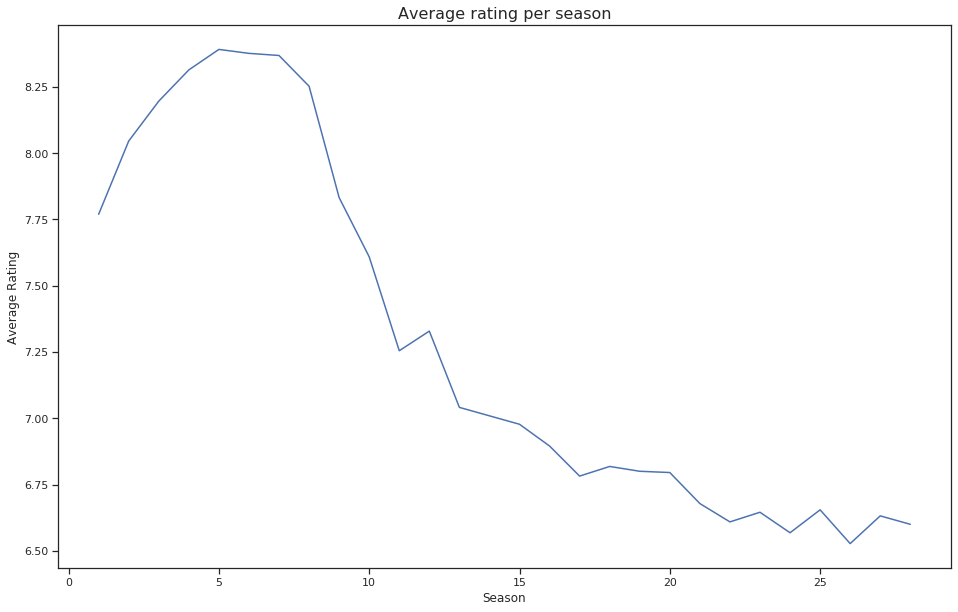

In [182]:
sns.lineplot(x='season',y='rating',data=df.groupby('season').mean()['rating'].reset_index())
plt.title("Average rating per season", size=16)
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.show()

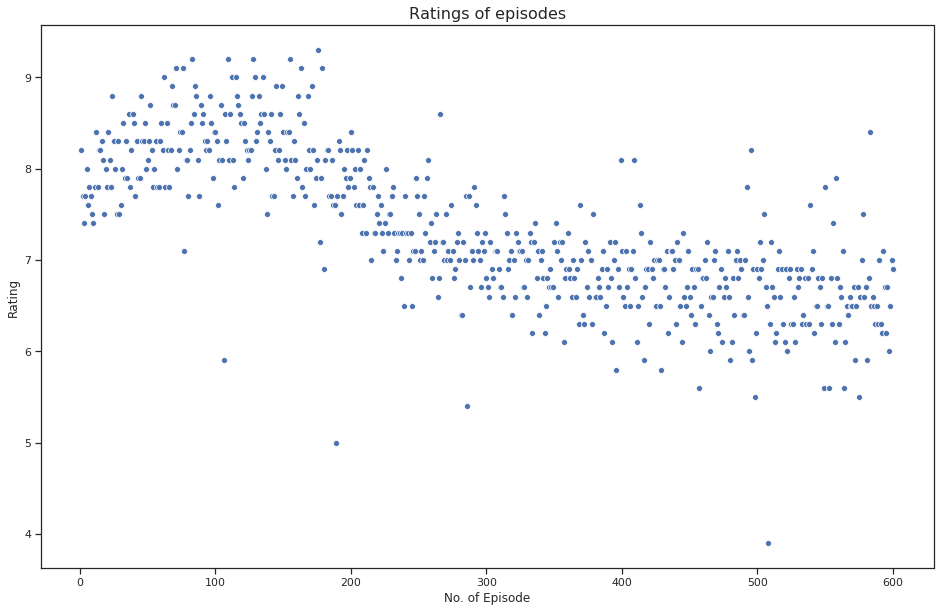

In [183]:
sns.scatterplot(x='no_overall',y='rating',data=df)
plt.title("Ratings of episodes", size=16)
plt.xlabel("No. of Episode")
plt.ylabel("Rating")
plt.show()

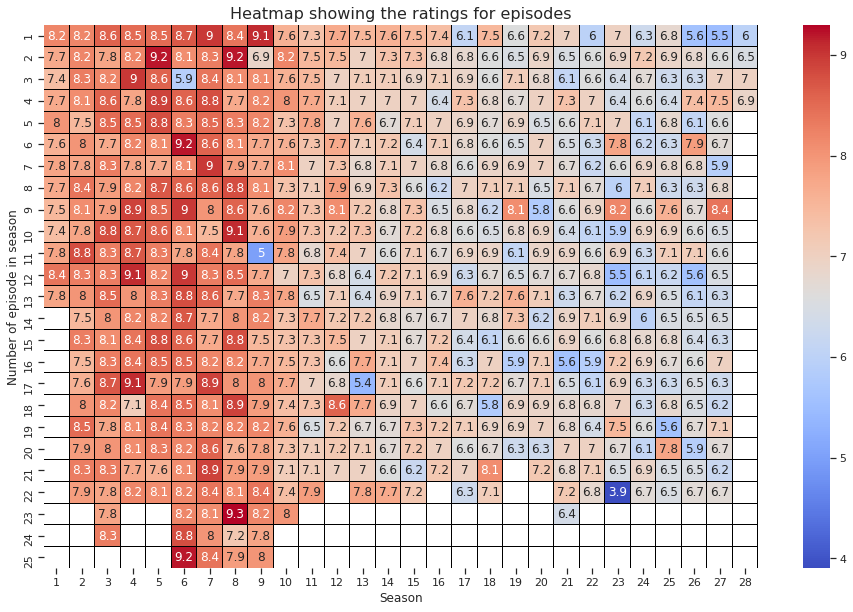

In [184]:
ax = sns.heatmap(df[['rating','no_in_season','season']].pivot_table(columns='season',index='no_in_season',values='rating'),
                 annot=True,
                 cmap='coolwarm',
                linewidth=0.05,
                linecolor='black')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatmap showing the ratings for episodes", size=16)
plt.ylabel("Number of episode in season")
plt.xlabel("Season")
plt.show()

The past three plots visualize the decline over the years. While each season has its lowpoints, the quality (rating) of episodes has been going down over the past years. 

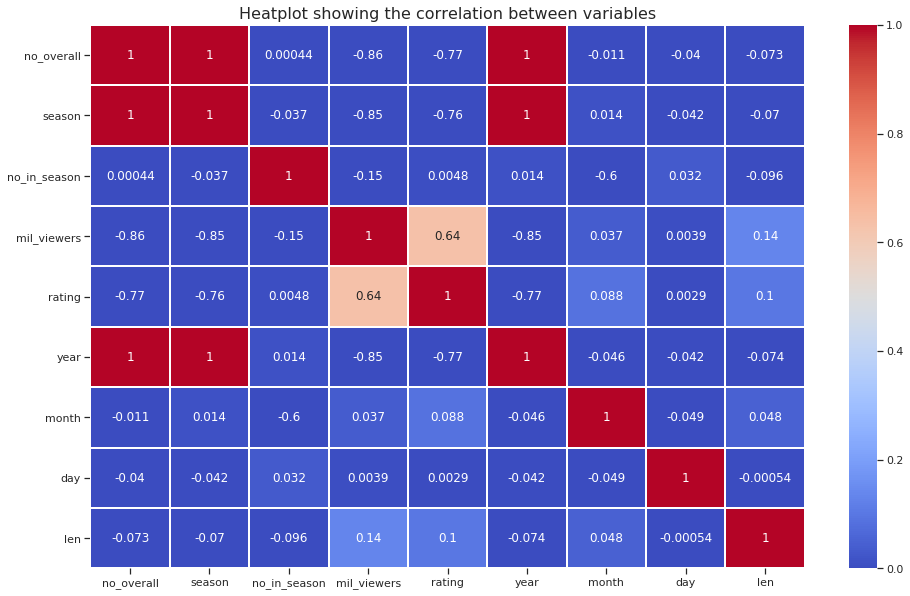

In [185]:
ax = sns.heatmap(df.corr(), annot=True,vmin=0.0, vmax=1.0, cmap='coolwarm',linewidths=1) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Heatplot showing the correlation between variables", size=16)
plt.show()

There seems to be some correlation between how many are watching the episode and how highly it is rated. 

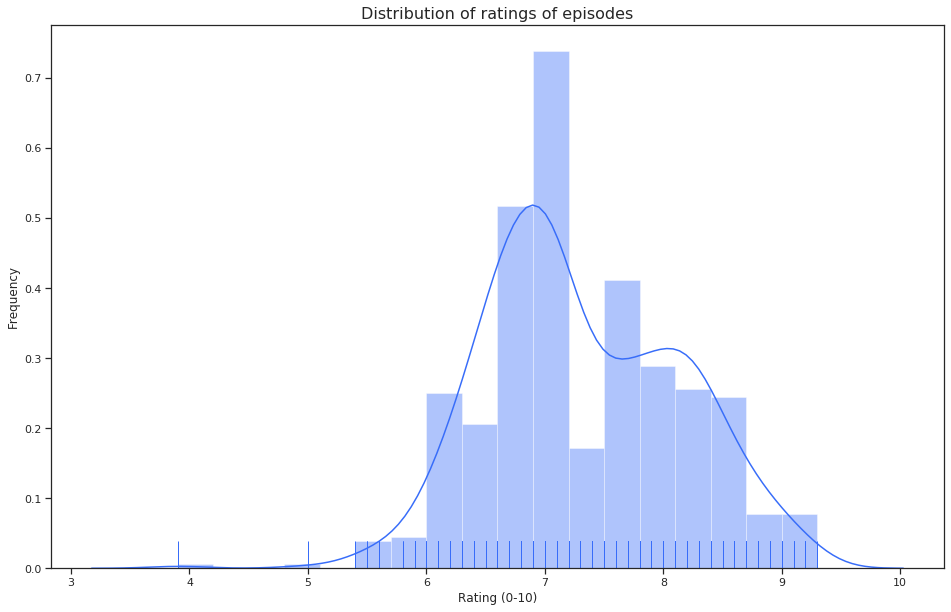

In [186]:
sns.set_palette('rainbow')
sns.distplot(df['rating'], rug=True)
plt.title("Distribution of ratings of episodes", size=16)
plt.xlabel("Rating (0-10)")
plt.ylabel("Frequency")
plt.show()

Most episodes are scoring a rating between 6 and 8.5

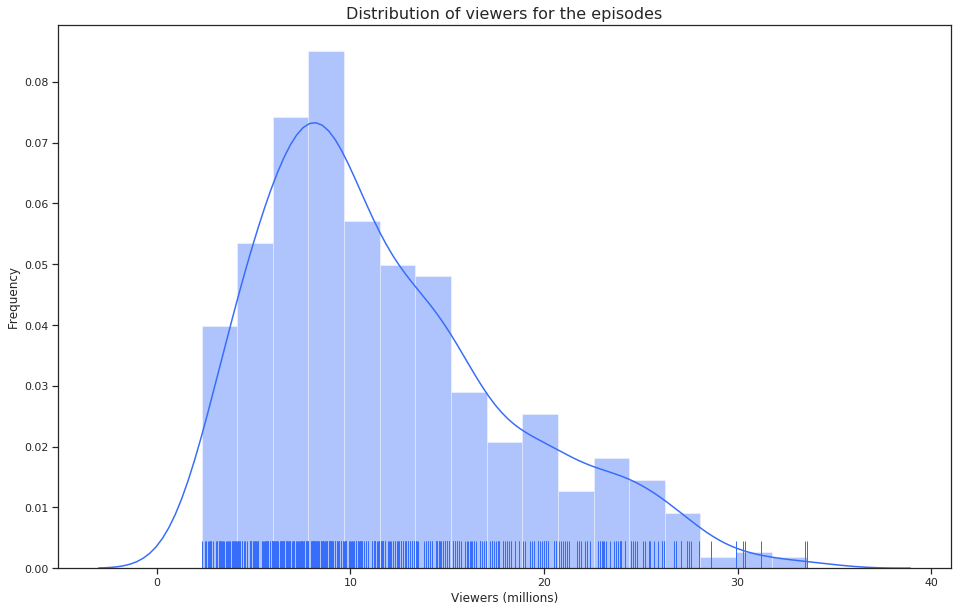

In [187]:
sns.distplot(df['mil_viewers'], rug=True)
plt.title("Distribution of viewers for the episodes", size=16)
plt.xlabel("Viewers (millions)")
plt.ylabel("Frequency")
plt.show()

Most episodes have around 5-15 million viewers. 

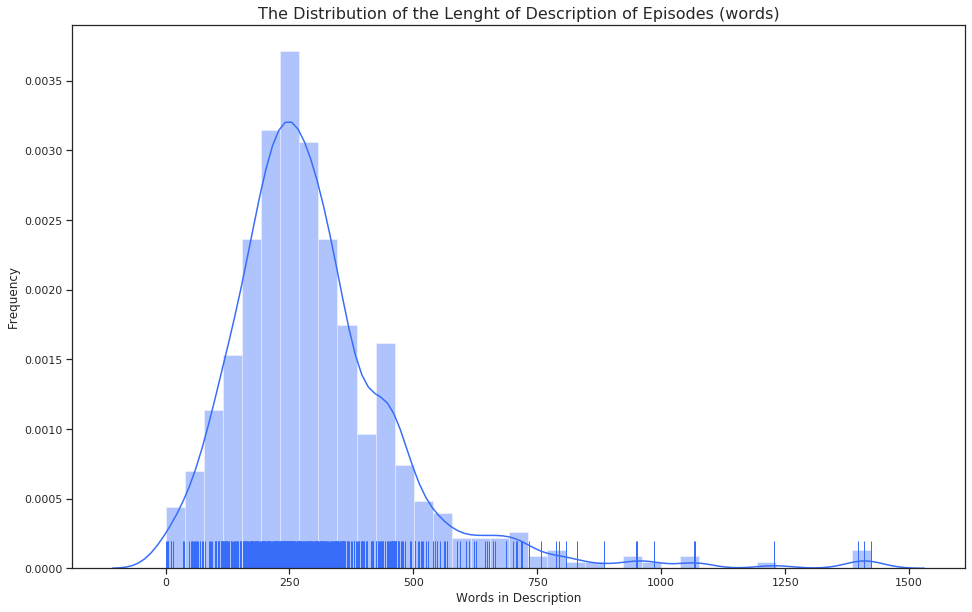

In [188]:
sns.distplot(df[df['len']>0]['len'], rug=True)
plt.title("The Distribution of the Lenght of Description of Episodes (words)", size=16)
plt.xlabel("Words in Description")
plt.ylabel("Frequency")
plt.show()

In the plot above it can be seen that most episodes have quite a large text that describes it.

# Linear Regression - For comparison

In order to see if the new topical model is more accurate than a normal linear regression model, a simple linear regression model was created in order to try and predict the rating of an episode. 

In [189]:
df.columns

Index(['no_overall', 'season', 'no_in_season', 'episode_name', 'mil_viewers',
       'rating', 'year', 'month', 'day', 'desc', 'len', 'tf_idf'],
      dtype='object')

In [190]:
X = df[['no_overall','no_in_season','season','mil_viewers','year','month','day']].values

In [191]:
y = df['rating'].values

In [192]:
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [193]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [195]:
lm = LinearRegression()

In [196]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [197]:
predictions = lm.predict(X_test)

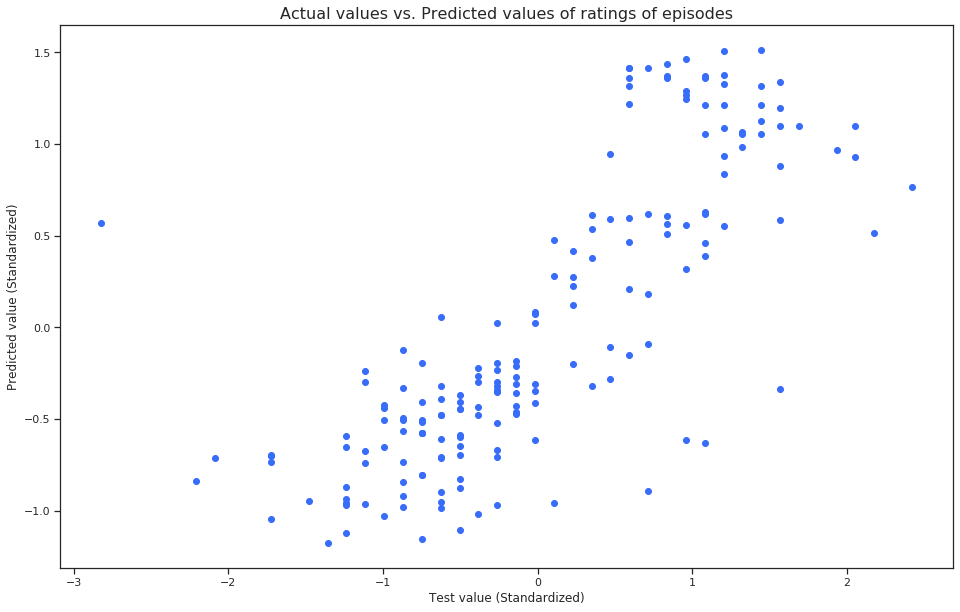

In [198]:
plt.scatter(y_test,predictions)
plt.title("Actual values vs. Predicted values of ratings of episodes", size=16)
plt.xlabel("Test value (Standardized)")
plt.ylabel("Predicted value (Standardized)")
plt.show()

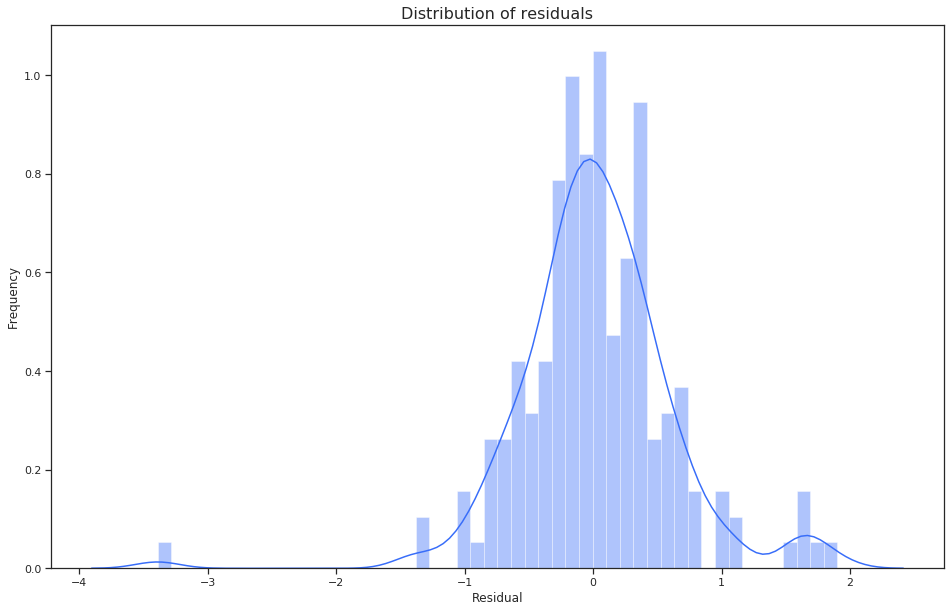

In [199]:
sns.distplot((y_test-predictions),bins=50);
plt.title("Distribution of residuals", size=16)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [200]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.4211725610700589
MSE: 0.3619490468774963
RMSE: 0.6016220132919807


From this it can be seen that creating a linear regression model in order to predict an episode's rating from other features is somewhat achievable.

# 5. Research Question<a class="anchor" id="five"></a>

By using *Topic Modeling* and *Latent Dirichlet Allocation*, we hope to uncover some of the hidden features of the episodes. We hope to see if there is any relation between the topic of episodes and their respective rating. 

We want to see how each episode relates to the topics, i.e. how the topic proportions align with the episodes and if that can be used to determine an episode's rating. If the topic allocations and proportions of an episode can help determine an episode's rating, not only have be created a better linear regression model, but we have proven a hypothesis which does seem logical - *an episode's rating is related to what is happening in the episode.* 

In order to carry out *topic modeling*, the number of topics, $K$, has to be assumed. 

# 6. Generative Story<a class="anchor" id="six"></a>

As we will deploy *Latent Dirichlet Allocation* for our topic model, the generative story for the inference of topics will follow the same generative story LDA follows. Here, we have changed the wording to fit our project. The following will be the generative story our model will follow: 

1. For each topic $k \in \{1,2,...,K\}$ where $K$ is the assumed total number of topics, there is a vector of $C$ words, $\phi_k$, such that $p(\theta_k|\beta) = \text{Dir}(\beta)$

2. For each document (*episode*) $i$:

>a) There is a vector of $K$ topics, $\theta_i$, such that $p(\theta_i|\alpha) = \text{Dir}(\alpha)$
    
>b) For each of the words $j$ in each episode $i$, where $j\in \{1,2,...,||w_i||\}$, we have
    
>>i) A **topic assignment** $z_{i,j} \in \{1,2,...,K\}$ such that $p(z_{i,j}|\theta_i) = \text{Cat}(\theta_i)$
    
>>ii) A **word** $w_{i,j}$ such that $p(w_{i,j}|\phi_{z_{i,j}}) = \text{Cat}(\phi_{z_{i,j}})$

What this means is that each episode will get assigned topic proportions and each topic will get assigned word proportions. 


# 7. PGM <a class="anchor" id="seven"></a>

![title](pgm.png)

# 8. Stan Model <a class="anchor" id="eight"></a>

In [201]:
LDA_STAN="""
data{
    int<lower=1> I;
    int<lower=1> J[I];  // We mean J=||W_i||
    int<lower=2> K;
    int<lower=2> C;
    vector<lower=0>[K] alpha;
    vector<lower=0>[C] beta;
    int<lower=2> MAX_J;
    int W[I,MAX_J];
}

parameters{
    simplex[K] theta[I];
    simplex[C] phi[K];
}

model{
    for (k in 1:K)
        phi[k]~dirichlet(beta);
        
    for (i in 1:I){
        theta[i]~dirichlet(alpha);
        
        for (j in 1:J[i]){
                real gamma[K];
                for (k in 1:K)
                    // log(P(z = k | theta)) + log(P(W | phi, z = k)) 
                    gamma[k]=log(theta[i,k])+log(phi[k,W[i][j]]);
                
                target+=(log_sum_exp(gamma));
        }
    }
}

"""

####testa ekki-stan modelið héðan; https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [202]:
data_lemmatized = df['tf_idf']#.to_list()

In [203]:
data_lemmatized 

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

"Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 7) above implies, word id 0 occurs seven times in the first document."

In [204]:
# Build LDA model
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [205]:
from pprint import pprint
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [211]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v') #u_mass  eða c_v
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


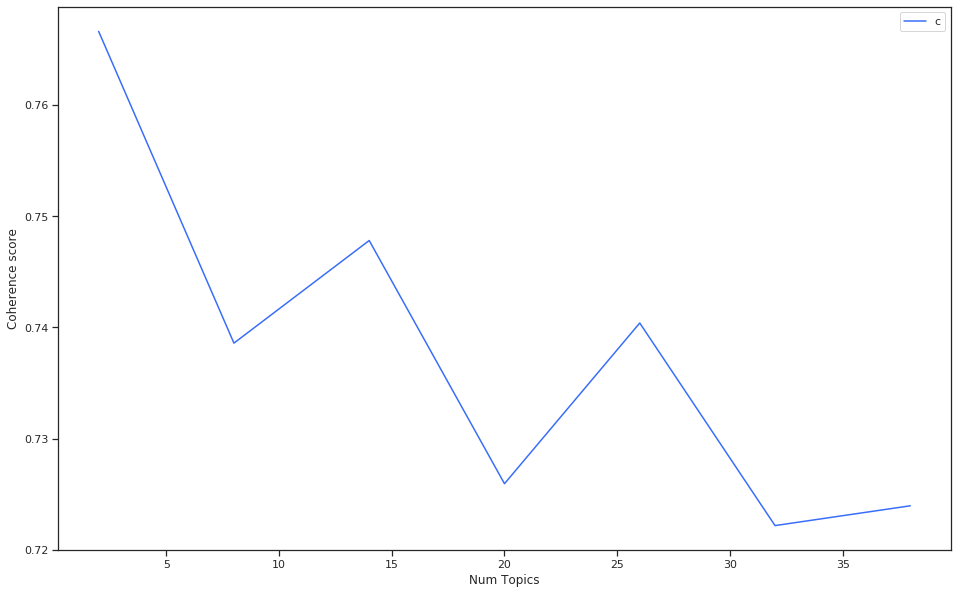

In [217]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [208]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
lda_model=gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32)
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
29    -0.010262  0.002675       1        1  7.628071
30    -0.023848  0.020483       2        1  6.630059
28    -0.027925 -0.006260       3        1  6.335714
20    -0.032748 -0.009700       4        1  6.053583
24    -0.009270 -0.004365       5        1  5.486302
2     -0.016220 -0.006516       6        1  4.541589
27    -0.011133 -0.008025       7        1  4.415847
26     0.020179 -0.027500       8        1  3.875075
10    -0.006597 -0.009860       9        1  3.832809
1     -0.018210  0.018409      10        1  3.701555
8     -0.014458  0.003792      11        1  3.429618
16    -0.004877 -0.013357      12        1  3.256947
17    -0.000745 -0.002577      13        1  2.826411
13    -0.013214  0.002095      14        1  2.806759
11    -0.000111 -0.010916      15        1  2.714545
15     0.001233  0.004208      16        1  2.714502
31    -0.034299 -0.010270      17        1  2.551892
3      0.005075 -0.025557      18        1  2.506647
4      0.004076 -0.008034      19        1  2.413739
5      0.002537  0.000215      20        1  2.381815
0     -0.008814  0.005605      21        1  2.351212
9      0.019007 -0.019942      22        1  2.252486
19    -0.010894 -0.007234      23        1  2.108973
21     0.000742  0.057930      24        1  1.874936
14     0.037090  0.003206      25        1  1.849450
7      0.047122  0.026903      26        1  1.710278
23     0.012338  0.036032      27        1  1.697942
18     0.007019  0.008672      28        1  1.676826
12     0.001063  0.018317      29        1  1.219061
25     0.043789  0.001052      30        1  1.207811
22     0.000776 -0.010350      31        1  1.015960
6      0.041577 -0.029131      32        1  0.931585, topic_info=     Category        Freq         Term       Total  loglift  logprob
17    Default  284.000000         bart  284.000000  30.0000  30.0000
1685  Default  267.000000        homer  267.000000  29.0000  29.0000
1340  Default  184.000000  springfield  184.000000  28.0000  28.0000
69    Default  186.000000       family  186.000000  27.0000  27.0000
115   Default  255.000000        marge  255.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
1538  Topic32    1.069650          day  123.500191  -0.0729  -6.7645
69    Topic32    1.088898       family  186.976944  -0.4698  -6.7467
413   Topic32    1.008372        burns  125.350456  -0.1467  -6.8235
457   Topic32    0.996746         find  105.600098   0.0131  -6.8351
1679  Topic32    1.005662         gets  158.899414  -0.3866  -6.8262

[2532 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
15798      1  0.343822     1952
5551      17  0.598666     1983
2542      11  0.600195     27th
8221       6  0.548832      315
15280     12  0.629713   4000th
...      ...       ...      ...
4890       2  0.479774    yahoo
12343      5  0.569555    yokel
17315      6  0.553059  zangler
9697       7  0.575166  zealots
15797      9  0.308683      zii

[9588 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[30, 31, 29, 21, 25, 3, 28, 27, 11, 2, 9, 17, 18, 14, 12, 16, 32, 4, 5, 6, 1, 10, 20, 22, 15, 8, 24, 19, 13, 26, 23, 7])